# Workgroup 4

Authors: Valerie Dube, Erzo Garay, Juan Marcos Guerrero y Matias Villalba

## Bootstraping

## Causal Forest

In [122]:
# Libraries
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm

# Causal forest libraries
from econml.grf import RegressionForest
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

### 1. Preprocessing

In [123]:
# Import synthetic data from data folder
df = pd.read_csv("../../data/synthetic_data.csv")

In [124]:
df.head()

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   schoolid  10391 non-null  int64  
 1   Z         10391 non-null  int64  
 2   Y         10391 non-null  float64
 3   S3        10391 non-null  int64  
 4   C1        10391 non-null  int64  
 5   C2        10391 non-null  int64  
 6   C3        10391 non-null  int64  
 7   XC        10391 non-null  int64  
 8   X1        10391 non-null  float64
 9   X2        10391 non-null  float64
 10  X3        10391 non-null  float64
 11  X4        10391 non-null  float64
 12  X5        10391 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 1.0 MB


In [126]:
# Save school clusters in variable
school_id = df['schoolid'].astype('category').cat.codes

# Create a dummy matrix (one-hot encoding) for school IDs
school_mat = pd.to_numeric(df['schoolid'], errors='coerce')
school_mat = sm.add_constant(pd.get_dummies(df['schoolid'], drop_first=False)).iloc[:, 1:].values

# Calculate the size of each school group
school_size = school_mat.sum(axis=0)

In [127]:
# Fit treatment (w) OLS
formula = 'Z ~ ' + ' + '.join(df.columns.drop(['Z', 'Y']))
w_lm = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()

# Print summary of the GLM model
print(w_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Z   No. Observations:                10391
Model:                            GLM   Df Residuals:                    10379
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6519.5
Date:                Thu, 06 Jun 2024   Deviance:                       13039.
Time:                        20:51:37   Pearson chi2:                 1.04e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007280
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0758      0.146     -7.348      0.0

In the previous OLS, we can observe that only the ctudent’s self-reported expectations for success (S3), student gender (C2), student first-generation status (C3), and school-level mean of students’ fixed mindsets (X1) variables are significat

In [128]:
# We define T, Y, and X_raw
Y = df['Y']
T = df['Z']
X_raw = df.drop(columns=['schoolid', 'Z', 'Y']) # School ID does not affect pscore
W = None

In [129]:
# Create model matrices for categorical variables
C1_exp = pd.get_dummies(X_raw['C1'], prefix='C1')
XC_exp = pd.get_dummies(X_raw['XC'], prefix='XC')

In [130]:
# Combine these matrices with the rest of the data
X = pd.concat([X_raw.drop(columns=['C1', 'XC']), C1_exp, XC_exp], axis=1)

We have a sample of 10,391 children from 76 schools, and we expand the categorical variables, resulting in 28 covariates, $X_i \in \mathbb{R}^{28}$

In [131]:
X

,S3,C2,C3,X1,X2,X3,X4,X5,C1_1,C1_2,...,C1_11,C1_12,C1_13,C1_14,C1_15,XC_0,XC_1,XC_2,XC_3,XC_4
0,6,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,...,False,False,False,False,False,False,False,False,False,True
1,4,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,...,False,True,False,False,False,False,False,False,False,True
2,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,...,False,False,False,False,False,False,False,False,False,True
3,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,...,False,False,False,False,False,False,False,False,False,True
4,6,1,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,...,False,False,False,False,False,False,False,False,True,False
10387,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,...,False,False,False,False,False,False,False,False,True,False
10388,2,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,...,False,False,False,False,True,False,False,False,True,False
10389,5,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,False,False,...,False,False,False,False,False,False,False,False,True,False


For each sample $i$, the authors consider potential outcomes $Y_i(0)$ and $Y_i(1)$, representing the outcomes if the $i$-th sample had been assigned to control $(W_i=0)$ or treatment $(W_i=1)$, respectively. We assume that we observe $Y_i = Y_i(W_i)$. The average treatment effect is defined as $\tau = \mathbb{E} [Y_i(1) - Y_i(0)]$, and the conditional average treatment effect function is $\tau(x) = \mathbb{E} [Y_i(1) - Y_i(0) \mid X_i = x]$.

### 2. Causal Forest estimation and results

#### 2.1. Causal Forest

When using random forests, the authors aim to perform a non-parametric random effects modeling approach, where each school is presumed to influence the student's outcome. However, the authors do not impose any assumptions about the distribution of these effects, specifically avoiding the assumption that school effects are Gaussian or additive.

The causal forest (CF) method attempts to find neighbourhoods in the covariate space, also known as recursive partitioning. While a random forest is built from decision trees, a causal forest is built from causal trees, where the causal trees learn a low-dimensional representation of treatment effect heterogeneity. To built a CF, we use the post-treatment outcome vector ($Y$), the treatment vector ($T$), and the 28 parameters matrix ($X$).

In [132]:
np.random.seed(123)

forest_model = CausalForestDML(model_t=RegressionForest(),
                               model_y=RegressionForest(),
                               n_estimators=200, 
                               min_samples_leaf=4,
                               max_depth=50,
                               verbose=0, 
                               random_state=123)

tree_model = forest_model.fit(Y, T, X=X, W=W)

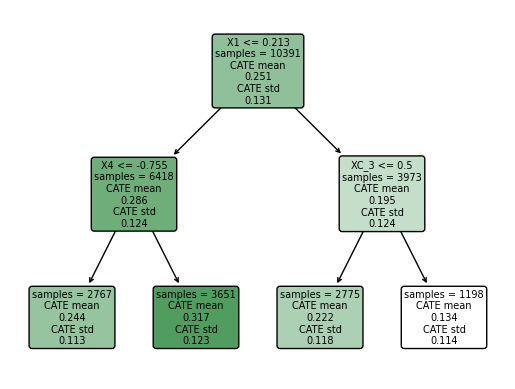

In [133]:
intrp = SingleTreeCateInterpreter(max_depth=2).interpret(forest_model, X)
intrp.plot(feature_names=X.columns, fontsize=7)

We found that the greater CATE is in the group of students that attendts to a school with a mean fixed mindset level lower than 0.21 (that means, with larger values of growth mindset), and with a percentage of students who are from families whose incomes fall below the federal poverty line greater than -0.75. This means that 

#### 2.2. ATE

The package dml has a built-in function for average treatment effect estimation. First, we estimate the CATE ($\hat{\tau}$), where we can see it is around 0.2 and 0.4. Then, we find that the ATE value is around 0.25.

In [134]:
tau_hat = forest_model.effect(X=X) # tau(X) estimates
statistics.mean(tau_hat)

0.25106325917227695

Text(0.5, 1.0, 'CATE estimates')

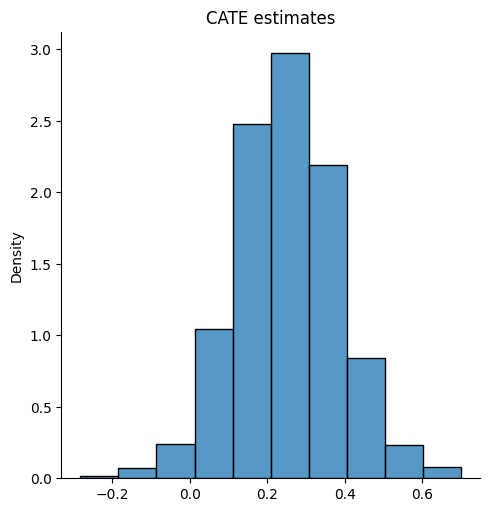

In [135]:
# Do not use this for assessing heterogeneity. See text above.
sns.displot(tau_hat, stat="density", bins = 10)
plt.title("CATE estimates")

The causal forest CATE estimates exhibit some variation, from -0.2 to 0.6.

#### 2.3. Run best linear predictor analysis

In [136]:
# Assuming cf is an instance of an EconML estimator
# and tau_hat is the estimated Conditional Average Treatment Effect (CATE)

# Compare regions with high and low estimated CATEs
high_effect = tau_hat > np.median(tau_hat)

# Calculate average treatment effect for high and low effect subsets
ate_high = tree_model.ate_inference(X=X[high_effect])
ate_low = tree_model.ate_inference(X=X[~high_effect])

In [137]:
ate_high

In [138]:
ate_low

In [117]:
# Calculate 95% confidence interval for the difference in ATEs
difference_in_ate = 0.355 - 0.148
ci_width = norm.ppf(0.975) * np.sqrt(0.122**2 + 0.121**2)

print(f"95% CI for difference in ATE: {difference_in_ate:.3f} +/- {ci_width:.3f}")

95% CI for difference in ATE: 0.207 +/- 0.337


In [140]:
# The fitted causal forest model should provide these values:
cf_W_hat = tree_model.propensity_  # Estimated treatment probability (cf$W.hat)
cf_Y_hat = tree_model.predict(X)   # Predicted outcome (cf$Y.hat)

# Calculate dr.score
dr_score = (
    tau_hat + 
    W / cf_W_hat * (Y - cf_Y_hat - (1 - cf_W_hat) * tau_hat) -
    (1 - W) / (1 - cf_W_hat) * (Y - cf_Y_hat + cf_W_hat * tau_hat)
)

# Calculate school.score
school_score = np.dot(school_mat.T, dr_score) / school_size

NameError: name 'dr_score' is not defined

#### 2.4. Look at school-wise heterogeneity

TypeError: '<' not supported between instances of 'ellipsis' and 'float'

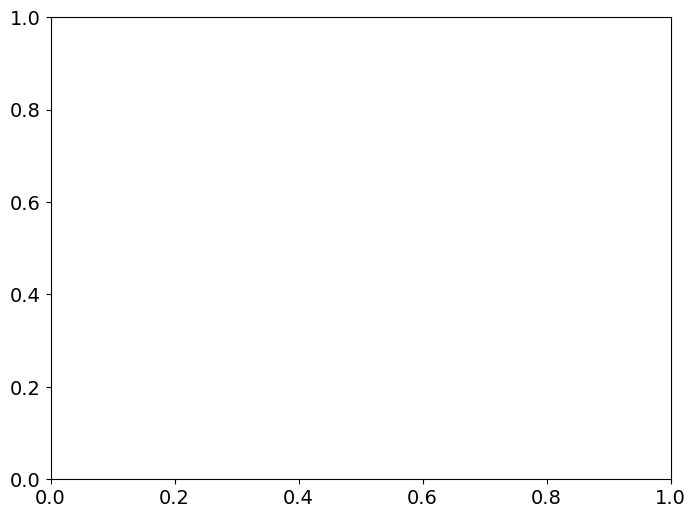

In [142]:
# Set up plot parameters
plt.rcParams.update({'font.size': 14})  # Adjust the font size

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(school_score, bins=30, edgecolor='black')
plt.xlabel('School Treatment Effect Estimate', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('')

# Save the plot as a PDF
plt.savefig('school_hist.pdf')

# Close the plot
plt.close()

#### 2.5. Analysis ignoring clusters. How do the results change?

#### 2.6. Analysis without fitting the propensity score

#### 2.7. The code plot six plots in the Make some plots section, so explain what you find there.

#### 2.8. Visualize school-level covariates by treatment heterogeneity

#### 2.9. CATE by school